# A robust candidate generation algorithm when the input space is discrete

### At first, the Brain function with discrete input space is optimized using traditional Bayesian optimization. Second a cure algorithm is applied. `random_seed` is set to 10 since under this seed the problem becomes very challenging.

### Import necessary modules

In [1]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods.gaussian_likelihood import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from ax.core import SimpleExperiment
from ax.modelbridge import get_sobol
from ax import ParameterType, SearchSpace, RangeParameter
import numpy as np
from ax.modelbridge.factory import get_botorch
import random
import torch

random_seed = 10
initial_samples = 10
opt_iterations = 20
bounds = ((-5, 10), (0, 15))
# the steps for each parameter
intervals = (0.6, 0.6)

### Define a GP surrogate model

In [2]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

### Define a function to build GP and fit GP, return the fitted GP

In [3]:
def get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

### Define the optimization problem
You can change this function to your optimization problem, only keep the arguments *(X)* and return *{name: (y, 0.0)}* unchanged.

Note that the `sampled_input` is for plotting and checking if an input has been generated.

In [4]:
name = "branin"
sampled_input = {}

def branin(X):
    x1, x2 = X["x1"], X["x2"]
    
    y = (x2 - 5.1 / (4 * np.pi ** 2) * x1 ** 2 + 5 / np.pi * x1 - 6) ** 2
    y += 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10
    # let's add some synthetic observation noise
    y += random.normalvariate(0, 0.1)
    # using string to safely compare if the inputs have been generated
    try:
        input_label = f"{format(x1, '.3f')}, {format(x2, '.3f')}"
        sampled_input[input_label] = (x1, x2)
    except:
        pass
    return {name: (y, 0.0)}

### Build an experiment and return

In [5]:
def build_exp(search_space, seed, minimize=True):
    exp = SimpleExperiment(
        name=name,
        search_space=search_space,
        evaluation_function=branin, # should be the same function name you defined in last step
        objective_name=name,
        minimize=minimize,
    )
    sobol = get_sobol(exp.search_space, seed=seed)
    exp.new_batch_trial(generator_run=sobol.gen(initial_samples))
    return exp

### Define the optimization loop

This loop is different from the Botorch tutorial. In that tutorial, the optimization stops after generating a sample, i.e. training -> generating -> training -> ... -> training -> generating.

With this loop, the optimization stops after training a final model. The number of all samples is the same with what we defined.

In [6]:
def optimize(search_space, seed, minimize=True):
    exp = build_exp(search_space, seed, minimize)
    # buiding the initial GP
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_simple_custom_gp,
    )
    # start optimization loop
    for i in range(opt_iterations):
        generator_run = model.gen(1)
        exp.new_trial(generator_run=generator_run)
        model = get_botorch(
            experiment=exp,
            data=exp.eval(),
            search_space=exp.search_space,
            model_constructor=get_and_fit_simple_custom_gp
        )
        print(f"Running optimization batch {i + 1}/{opt_iterations}...")
    print("Done!")
    return model

### Optimizing the Branin funciton

In [7]:
from ax import ChoiceParameter
import warnings
warnings.filterwarnings("ignore")

parameter_space = SearchSpace(
    parameters=[
        ChoiceParameter(
            name="x1",
            parameter_type=ParameterType.FLOAT,
            values=torch.arange(bounds[0][0], bounds[0][1]+1e-6, intervals[0]),
            is_ordered=True,
            sort_values=True
        ),
        ChoiceParameter(
            name="x2",
            parameter_type=ParameterType.FLOAT,
            values=torch.arange(bounds[1][0], bounds[1][1]+1e-6, intervals[1]),
            is_ordered=True,
            sort_values=True
        )
    ]
)
model = optimize(
    search_space=parameter_space,
    seed=random_seed 
)

Running optimization batch 1/20...
Running optimization batch 2/20...
Running optimization batch 3/20...
Running optimization batch 4/20...
Running optimization batch 5/20...
Running optimization batch 6/20...
Running optimization batch 7/20...
Running optimization batch 8/20...
Running optimization batch 9/20...
Running optimization batch 10/20...
Running optimization batch 11/20...
Running optimization batch 12/20...
Running optimization batch 13/20...
Running optimization batch 14/20...
Running optimization batch 15/20...
Running optimization batch 16/20...
Running optimization batch 17/20...
Running optimization batch 18/20...
Running optimization batch 19/20...
Running optimization batch 20/20...
Done!


### Plot the GP model and samples

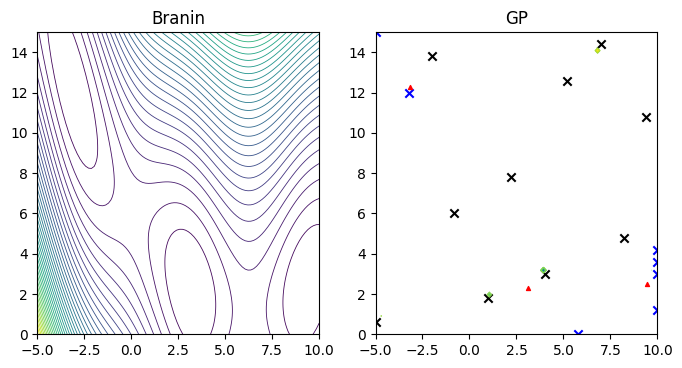

In [8]:
import matplotlib.pyplot as plt
from ax.models.torch.utils import predict_from_model
import torch
import gpytorch

# GP takes normalized input between (0, 1)
n = 100
x1= torch.linspace(0, 1, n).reshape((-1, 1))
x2 = torch.linspace(0, 1, n).reshape((-1, 1))
x1_x2= torch.cat((x1, x2), 1)
x1_x2 = gpytorch.utils.grid.create_data_from_grid(x1_x2)

pred, var = predict_from_model(model.model.model, x1_x2)
pred = pred.numpy().reshape(n, n)

# We plot GP using real range
x1= torch.linspace(-5, 10, n).reshape((-1, 1))
x2 = torch.linspace(0, 15, n).reshape((-1, 1))
x1, x2 = np.meshgrid(x1, x2)

plt.figure(figsize=(8, 4), dpi=100)
# plot true branin
plt.subplot(1, 2, 1)
plt.contour(x1, x2, branin({"x1": x1, "x2": x2})[name][0], linewidths=0.6, levels=50)
plt.title("Branin")
# plot GP
# black crosses are initial samples, blues are opt samples and red triangles are real minimums
plt.subplot(1, 2, 2)
plt.contour(x1, x2, pred, linewidths=0.6, levels=50)
i = 0
for _, x in sampled_input.items():
    color = "black" if i < initial_samples else "blue"
    plt.scatter(x[0], x[1], c=color, marker="x")
    i += 1
# plot the analytical solutions
plt.scatter([-np.pi, np.pi, 9.42478], [12.275, 2.275, 2.475], c="red", marker="^", s=8)
plt.title("GP")

plt.show()

For tradition algorithm and under this random seed, the BO fails to find a solution. In the worst scenario, a valid GP can not be fitted due to catastrophic numerical instability.

In the following, we proposed an contraint optimization based candidate generation algorithm. It follows as:
1. checking if a candidate has been evaluated,
2. create an constraint that the cell centered at current candidate is excluded from the optimization domain,
3. iteratively find the new candidate using upper confidence bound algorithm until the new candidate is not overlapped with existing ones
4. if the non-overlapping candidate can not be found after 5 iterations, a random input is returned

In [9]:
from ax.models.torch.botorch_defaults import optimize_acqf
from scipy.optimize import minimize
# bounds is a global variable
axes = np.array([intervals[i] / (bounds[i][1] - bounds[i][0]) for i in range(len(bounds))])
valid_normalized_samples = np.array([np.arange(0, 1 + 1e-6, axes[i]) for i in range(len(bounds))])
constraints_ = []

def rounder(values):
    def f(x):
        idx = np.argmin(np.abs(values - x))
        return values[idx]
    return np.frompyfunc(f, 1, 1)
'''
round to the nearest value

a = np.array([0, 0.5, 1])
b = np.array([0.1, 0.3, 0.8, 1.2, 2])
rounded = rounder(a)(b)
gives: [0, 0.5, 1, 1, 1]
'''

def candidate_existing(acq_cand):
    acq_cand_to_gridpoint = [rounder(valid_normalized_samples[i])(acq_cand[i]) for i in range(len(bounds))]
    acq_cand_to_funcbounds = [acq_cand_to_gridpoint[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0] for i in range(len(bounds))]
    
    acq_cand_to_funcbounds_label = f"{format(acq_cand_to_funcbounds[0], '.3f')}, {format(acq_cand_to_funcbounds[1], '.3f')}"
    return acq_cand_to_funcbounds_label in sampled_input.keys()
    
    
# main algorithm 
def get_constraint_optimized_cand(model, acq_cand):
    print(acq_cand)
    if not candidate_existing(acq_cand.squeeze().numpy()):
        return acq_cand
    
    existing_inputs = np.array([value for _, value in sampled_input.items()])
    normalized_existing_inputs = np.zeros_like(existing_inputs)
    for i in range(len(bounds)):
        normalized = (existing_inputs[:, i] - bounds[i][0]) / (bounds[i][1] - bounds[i][0])
        normalized_existing_inputs[:, i] = rounder(valid_normalized_samples[i])(normalized)
        
    # acq_cand is an value that has not been rounded to grid point
    acq_cand_to_gridpoint = [rounder(valid_normalized_samples[i])(acq_cand.numpy()[0][i]) for i in range(len(bounds))]

    n_iter = 0
    regenerate = False
    
    while n_iter < 5:
#         if acq_x_int in raw_inputs.astype(int).tolist():
        regenerate = True
        n_iter += 1
        print(f"--- Constrained minimizing started! iteration {n_iter} ---")

        if len(bounds) == 2:
            cons = {'type': 'ineq',
                    'fun': lambda x: ((x[0] - acq_cand_to_gridpoint[0]) / (axes[0] / 2)) ** 6 +
                                     ((x[1] - acq_cand_to_gridpoint[1]) / (axes[1] / 2)) ** 6 - 1.1}
        else:
            raise Exception(f"Such dimension is invalid.")
        
        constraints_.append(cons)
        res = multistart_minimize(fun, model, constraints_)
        
        res_gridpoint = np.zeros_like(res)
        for i in range(len(bounds)):
            res_gridpoint[:, i] = rounder(valid_normalized_samples[i])(res[:, i])
        
        res_gridpoint = np.unique(res_gridpoint, axis=0)
        for generated_candidate in res_gridpoint:
            satisfied = []
            for cons in constraints_:
                satisfied.append(cons['fun'](generated_candidate) > 0)
            if False in satisfied:
                continue
            if not candidate_existing(generated_candidate):
                print("\tNon-repeated cand: ", torch.tensor(np.expand_dims(generated_candidate, 0)))
                return torch.tensor(np.expand_dims(generated_candidate, 0))
    print("\tRandom cand: ", torch.tensor(np.expand_dims(np.random.rand(len(bounds)), 0)))
    return torch.tensor(np.expand_dims(np.random.rand(len(bounds)), 0))

def multistart_minimize(fun, model, constraints_):
    n = 50 * len(bounds)
    starts = np.random.rand(n).reshape(-1, len(bounds))
    x_array, fun_array = [], []
    for x0 in starts:
        res = minimize(fun, x0, args=(model), method='SLSQP', bounds=[(0, 1)] * len(bounds),
                       constraints=constraints_, options={'disp': False})
        if res['success']:
            x_array.append(res['x'])
            fun_array.append(res['fun'])
    sort_index = np.array(fun_array).argsort()
    return np.array(x_array)[sort_index]

# this is actually an upper confidence bound function
# UCB(x) = mu(x) + sqrt(beta) * sigma(x)`, where `mu` and `sigma` are the posterior mean and standard deviation, respectively.
# the posterior standard deviation weighted by a trade-off parameter, `beta`
def fun(x, model):
    beta = 0.1
    X = torch.tensor([x])
    posterior = model.posterior(X=X)
    mean = posterior.mean.detach().numpy()
    variance = posterior.variance.detach().numpy()
    return (mean - np.sqrt(beta) * variance).squeeze()

# a modification of the original 'scipy_optimizer' function.
def scipy_optimizer_discrete(
    acq_function,
    bounds,
    n: int,
    inequality_constraints = None,
    fixed_features = None,
    rounding_func = None,
    **kwargs,
):
    num_restarts: int = kwargs.get("num_restarts", 20)
    raw_samples: int = kwargs.get("num_raw_samples", 50 * num_restarts)

    if kwargs.get("joint_optimization", False):
        sequential = False
    else:
        sequential = True
        # use SLSQP by default for small problems since it yields faster wall times
        if "method" not in kwargs:
            kwargs["method"] = "SLSQP"

    X, expected_acquisition_value = optimize_acqf(
        acq_function=acq_function,
        bounds=bounds,
        q=n,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options=kwargs,
        inequality_constraints=inequality_constraints,
        fixed_features=fixed_features,
        sequential=sequential,
        post_processing_func=rounding_func,
    )
    # here we call the algorithm
    X = get_constraint_optimized_cand(acq_function.model, X)
    return X, expected_acquisition_value

In [10]:
name = "branin"
sampled_input = {}

def build_exp(search_space, seed, minimize=True):
    exp = SimpleExperiment(
        name=name,
        search_space=search_space,
        evaluation_function=branin, # should be the same function name you defined in last step
        objective_name=name,
        minimize=minimize,
    )
    sobol = get_sobol(exp.search_space, seed=seed)
    exp.new_batch_trial(generator_run=sobol.gen(initial_samples))
    return exp


def optimize(search_space, seed, minimize=True):
    exp = build_exp(search_space, seed, minimize)
    # buiding the initial GP
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=get_and_fit_simple_custom_gp,
    )
    # start optimization loop
    for i in range(opt_iterations):
        generator_run = model.gen(1)
        exp.new_trial(generator_run=generator_run)
        model = get_botorch(
            experiment=exp,
            data=exp.eval(),
            search_space=exp.search_space,
            model_constructor=get_and_fit_simple_custom_gp,
            acqf_optimizer=scipy_optimizer_discrete
        )
        print(f"Running optimization batch {i + 1}/{opt_iterations}...")
    print("Done!")
    return model

del model
model = optimize(
    search_space=parameter_space,
    seed=random_seed 
)

Running optimization batch 1/20...
tensor([[0.9808, 0.2885]], dtype=torch.float64)
Running optimization batch 2/20...
tensor([[0.7115, 0.0192]], dtype=torch.float64)
Running optimization batch 3/20...
tensor([[0.0192, 0.9808]], dtype=torch.float64)
Running optimization batch 4/20...
tensor([[0.9808, 0.2500]], dtype=torch.float64)
Running optimization batch 5/20...
tensor([[0.9808, 0.2500]], dtype=torch.float64)
--- Constrained minimizing started! iteration 1 ---
	Non-repeated cand:  tensor([[0.1200, 0.8800]], dtype=torch.float64)
Running optimization batch 6/20...
tensor([[0.1346, 0.7885]], dtype=torch.float64)
Running optimization batch 7/20...
tensor([[0.9808, 0.2115]], dtype=torch.float64)
Running optimization batch 8/20...
tensor([[0.9808, 0.2115]], dtype=torch.float64)
--- Constrained minimizing started! iteration 1 ---
	Non-repeated cand:  tensor([[0.1200, 0.8400]], dtype=torch.float64)
Running optimization batch 9/20...
tensor([[0.8654, 0.6346]], dtype=torch.float64)
Running opt

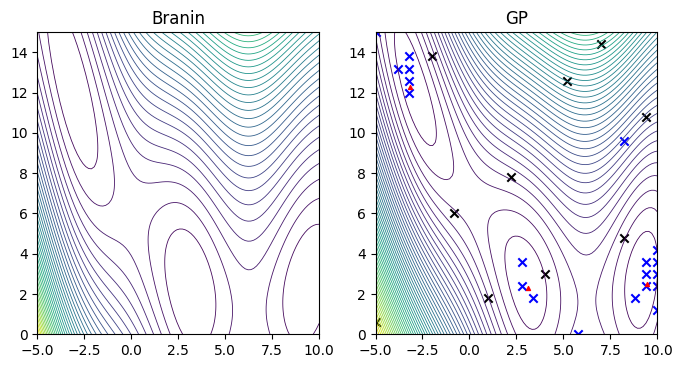

In [11]:
# GP takes normalized input between (0, 1)
n = 100
x1= torch.linspace(0, 1, n).reshape((-1, 1))
x2 = torch.linspace(0, 1, n).reshape((-1, 1))
x1_x2= torch.cat((x1, x2), 1)
x1_x2 = gpytorch.utils.grid.create_data_from_grid(x1_x2)

pred, var = predict_from_model(model.model.model, x1_x2)
pred = pred.numpy().reshape(n, n)

# We plot GP using real range
x1= torch.linspace(-5, 10, n).reshape((-1, 1))
x2 = torch.linspace(0, 15, n).reshape((-1, 1))
x1, x2 = np.meshgrid(x1, x2)

plt.figure(figsize=(8, 4), dpi=100)
# plot true branin
plt.subplot(1, 2, 1)
plt.contour(x1, x2, branin({"x1": x1, "x2": x2})[name][0], linewidths=0.6, levels=50)
plt.title("Branin")
# plot GP
# black crosses are initial samples, blues are opt samples and red triangles are real minimums
plt.subplot(1, 2, 2)
plt.contour(x1, x2, pred, linewidths=0.6, levels=50)
i = 0
for _, x in sampled_input.items():
    color = "black" if i < initial_samples else "blue"
    plt.scatter(x[0], x[1], c=color, marker="x")
    i += 1
# plot the analytical solutions
plt.scatter([-np.pi, np.pi, 9.42478], [12.275, 2.275, 2.475], c="red", marker="^", s=8)
plt.title("GP")

plt.show()